## Facebook posts - Topic Modelling

#### Dataset

- Posts made within the campaign period (Feb 12 - May 13, 2019) are taken from senatorial candidates' facebook page 
- Posts are translated to English
- Posts containing words pertaining to election campaign activities are removed to focus on posts related to platforms and the like.

In [1]:
import pandas as pd
import nltk; nltk.download('stopwords')

import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
#warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to C:\Users\Arjoselle
[nltk_data]     Ortiz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1. Import data

In [2]:
df = pd.read_csv('fb_posts_translated.csv')

#### a. Drop irrelevant columns.

In [3]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,Candidate,Translated_text
0,Bong Go,Happy Mother's Day From Tatay Digong!
1,Bong Go,Thank you so much to all of you!
2,Bong Go,"KUYA BONG GO, SATURDAY HOMETOWN DAVAO CITY FOR..."
3,Bong Go,Vhong Navarro has shown support for Kuya Bong ...
4,Bong Go,"Bong Go at Cogon Public Market, Cagayan de Oro..."


In [4]:
df.shape

(2664, 2)

In [5]:
pprint(df.iloc[0,1])

"Happy Mother's Day From Tatay Digong!"


#### b. Drop rows related to election campaign activities to focus on posts related to platforms and the like.

In [6]:
df.Translated_text = df.Translated_text.apply(lambda x: np.NaN if 'vote' in str(x).lower() else x)
df.Translated_text = df.Translated_text.apply(lambda x: np.NaN if 'thank' in str(x).lower() else x)
df.Translated_text = df.Translated_text.apply(lambda x: np.NaN if 'election' in str(x).lower() else x)
df.Translated_text = df.Translated_text.apply(lambda x: np.NaN if 'elections' in str(x).lower() else x)
df.Translated_text = df.Translated_text.apply(lambda x: np.NaN if 'senatorial' in str(x).lower() else x)
df.Translated_text = df.Translated_text.apply(lambda x: np.NaN if 'senator' in str(x).lower() else x)
df.Translated_text = df.Translated_text.apply(lambda x: np.NaN if 'ballot' in str(x).lower() else x)
df.Translated_text = df.Translated_text.apply(lambda x: np.NaN if 'candidate' in str(x).lower() else x)
df.Translated_text = df.Translated_text.apply(lambda x: np.NaN if 'campaign' in str(x).lower() else x)
df.Translated_text = df.Translated_text.apply(lambda x: np.NaN if 'rally' in str(x).lower() else x)
df.Translated_text = df.Translated_text.apply(lambda x: np.NaN if 'senado' in str(x).lower() else x)
df.Translated_text = df.Translated_text.apply(lambda x: np.NaN if 'balota' in str(x).lower() else x)

df.dropna(subset=['Translated_text'], inplace=True)
df.shape

(861, 2)

In [7]:
df.drop_duplicates(inplace=True)

### 2. Pre-process Data

In [8]:
# Convert to list
data = df.Translated_text.values.tolist()
len(data)

839

#### a. Prepare stopwords

In [9]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['thank', 'support', 'much', 'election', 'ballot', 'candidate', 'vote', 'campaign', 'ate', 'gracepoe', 'ating', 'cheldiokno', 'aking', 'nating', 'pampanga', 'watch', 'ng', 'avance', 'atty', 'live' ])

#### b. Tokenize words and Clean-up text

In [10]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))
data_words[0]

['happy', 'mother', 'day', 'from', 'tatay', 'digong']

#### c. Creating Bigram and Trigram Models

In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['happy', 'mother', 'day', 'from', 'tatay', 'digong']


#### d. Remove Stopwords, Make Bigrams and Lemmatize

In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        if 'nate' in texts_out:
            print(sent)
    return texts_out

In [13]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ','VERB', 'ADV'])

print(data_lemmatized[:1])

[[]]


#### e. Create the Dictionary and Corpus needed for Topic Modeling

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[]]


In [15]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[]]

### 3. Build the Model

Using Mallet LDA

In [16]:
import os
#C:\Users\Arjoselle Ortiz\Documents\DS Classes\Eskwelabs\Capstone\mallet-2.0.8\mallet-2.0.8\bin
os.environ.update({'MALLET_HOME':r'C:/new_mallet/mallet-2.0.8/'})
mallet_path = 'C:\\new_mallet\\mallet-2.0.8\\bin\\mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=id2word, random_seed=123) #initial topic=5

In [17]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.43355634819189526


### 3. Tune the Model

#### a. Optimal number of topics

4
5
6
7
8
9
10
11
12


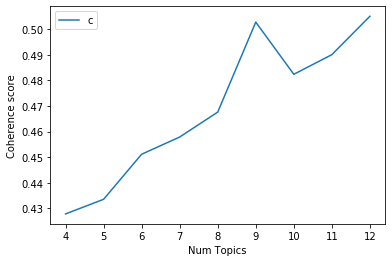

In [18]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word,
                                                random_seed=123)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

start1 = 4 
limit1 = 13
step1 = 1

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start1, limit=limit1, step=step1)

x = range(start1, limit1, step1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [19]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 4  has Coherence Value of 0.4279
Num Topics = 5  has Coherence Value of 0.4336
Num Topics = 6  has Coherence Value of 0.4512
Num Topics = 7  has Coherence Value of 0.4579
Num Topics = 8  has Coherence Value of 0.4676
Num Topics = 9  has Coherence Value of 0.5027
Num Topics = 10  has Coherence Value of 0.4824
Num Topics = 11  has Coherence Value of 0.49
Num Topics = 12  has Coherence Value of 0.505


We'll choose 9 topics as it has high coherence score and 
seems a reasonable number of topics to have.

#### b. Build optimal model

In [20]:
optimal_model = model_list[-4] # Number of Topics = 9

model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.042*"time" + 0.023*"today" + 0.023*"long" + 0.023*"poor" + 0.020*"water" '
  '+ 0.020*"official" + 0.017*"system" + 0.015*"countryman" + 0.014*"woman" + '
  '0.014*"disaster"'),
 (1,
  '0.085*"country" + 0.040*"public" + 0.025*"medicine" + 0.022*"back" + '
  '0.022*"law" + 0.018*"pay" + 0.018*"company" + 0.013*"war" + '
  '0.013*"incentive" + 0.012*"list"'),
 (2,
  '0.082*"good" + 0.048*"price" + 0.048*"market" + 0.030*"sell" + 0.030*"year" '
  '+ 0.028*"talk" + 0.019*"farmer" + 0.016*"town" + 0.016*"weight" + '
  '0.012*"salamat"'),
 (3,
  '0.087*"people" + 0.029*"friend" + 0.026*"serve" + 0.026*"life" + '
  '0.023*"business" + 0.022*"small" + 0.022*"love" + 0.022*"mother" + '
  '0.019*"morning" + 0.016*"full"'),
 (4,
  '0.038*"worker" + 0.032*"fight" + 0.030*"tax" + 0.028*"include" + '
  '0.025*"job" + 0.018*"child" + 0.018*"member" + 0.018*"rise" + 0.015*"noon" '
  '+ 0.015*"low"'),
 (5,
  '0.066*"make" + 0.032*"sakit" + 0.027*"service" + 0.023*"heart" + '
  '0.022*"studen

### 5. Evaluate Results

#### a. Visualize the topics-keywords

In [21]:
# Convert LDA Mallet to normal LDA since pyLDAvis only takes the latter for visualization
optimal_model2 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model2, corpus, id2word)
vis

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.167540 -0.007544       1        1  11.791218
1      0.208876  0.051399       2        1  11.582760
3     -0.015310 -0.050433       3        1  11.384427
2      0.161061 -0.167555       4        1  11.256490
8     -0.094766  0.313723       5        1  11.249552
0     -0.212455 -0.005771       6        1  10.901372
6      0.202098  0.214873       7        1  10.810347
5      0.118766 -0.221286       8        1  10.521697
4     -0.200731 -0.127406       9        1  10.502138, topic_info=           Term       Freq      Total Category  logprob  loglift
52       people  66.000000  66.000000  Default  30.0000  30.0000
11      country  66.000000  66.000000  Default  29.0000  29.0000
14         good  66.000000  66.000000  Default  28.0000  28.0000
85         make  48.000000  48.000000  Default  27.0000  27.0000
15   government  39.000000  39.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
995         low  10.451978  11.591454   Topic9  -4.2047   2.1501
852        noon  10.451978  11.617479   Topic9  -4.2047   2.1479
623         dam   4.645324   4.645324   Topic9  -5.0156   2.2536
611       share   8.129317  13.746809   Topic9  -4.4560   1.7283
293      change   6.967986  10.433531   Topic9  -4.6102   1.8499

[596 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1032      1  0.877596     abandon
1026      8  0.859480   abdominal
815       3  0.907638       abejo
1033      4  0.858000     ability
1034      1  0.877596  absolutely
...     ...       ...         ...
654       9  1.010834      worker
83        6  1.068092       wrong
573       4  0.993474        year
377       1  1.023862       young
659       6  0.890077       youth

[607 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 2, 4, 3, 9, 1, 7, 6, 5])

#### b. Dominant topic and its percentage contribution in each document

In [23]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.1111,"time, today, long, poor, water, official, syst...",Happy Mother's Day From Tatay Digong!
1,1,1.0,0.1285,"country, public, medicine, back, law, pay, com...",Vhong Navarro has shown support for Kuya Bong ...
2,2,2.0,0.1285,"good, price, market, sell, year, talk, farmer,...","Bong Go at Cogon Public Market, Cagayan de Oro..."
3,3,0.0,0.1944,"time, today, long, poor, water, official, syst...","VERY GOOD AND SO MUCH BONG GO, SHOWING SUPPORT..."
4,4,8.0,0.1333,"government, continue, call, chinese, sea, part...",The people will continue to fight for hope and...
5,5,0.0,0.1111,"time, today, long, poor, water, official, syst...","#13 AUSTRIA, Bernard Fernandez @ Butuan City"
6,6,0.0,0.1111,"time, today, long, poor, water, official, syst...",https://m.youtube.com/watch…
7,7,3.0,0.1321,"people, friend, serve, life, business, small, ...",Authentic Politics is what we need today!
8,8,6.0,0.1264,"give, local, meet, city, political, issue, dev...",The untold case of Bro. Mike Velarde
9,9,5.0,0.1449,"make, sakit, service, heart, student, provide,...",is your church or religious leader endorsing t...


In [24]:
df_dominant_topic['Dominant_Topic'].value_counts()

0.0    261
3.0     92
5.0     83
2.0     79
4.0     76
6.0     69
1.0     66
8.0     64
7.0     49
Name: Dominant_Topic, dtype: int64

In [25]:
df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0].sort_values('Topic_Perc_Contrib', ascending=False).iloc[:50]
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1].sort_values('Topic_Perc_Contrib', ascending=False).iloc[:50]
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 2].sort_values('Topic_Perc_Contrib', ascending=False).iloc[:50]
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 3].sort_values('Topic_Perc_Contrib', ascending=False).iloc[:50]
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 4].sort_values('Topic_Perc_Contrib', ascending=False).iloc[:50]
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 5].sort_values('Topic_Perc_Contrib', ascending=False).iloc[:50]
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 6].sort_values('Topic_Perc_Contrib', ascending=False).iloc[:50]
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 7].sort_values('Topic_Perc_Contrib', ascending=False).iloc[:50]
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 7].sort_values('Topic_Perc_Contrib', ascending=False).iloc[:50]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
814,814,0.0,0.4266,"time, today, long, poor, water, official, syst...","Good day, Philippines! Today, we seek to enlig..."
813,813,0.0,0.4031,"time, today, long, poor, water, official, syst...","Magandang araw, Pilipinas! Today, we seek to ..."
130,130,0.0,0.2685,"time, today, long, poor, water, official, syst...",I know how difficult it is to find a lawyer wi...
171,171,0.0,0.2321,"time, today, long, poor, water, official, syst...",Why I am here? Did I plan it? Not and never by...
478,478,0.0,0.2023,"time, today, long, poor, water, official, syst...",Maca-Romy Macalintal on human rights: It's har...
174,174,0.0,0.1966,"time, today, long, poor, water, official, syst...",1. ADOPT BAYANIHAN FEDERAL of PUNO DRAFT  FOC...
3,3,0.0,0.1944,"time, today, long, poor, water, official, syst...","VERY GOOD AND SO MUCH BONG GO, SHOWING SUPPORT..."
24,24,0.0,0.1941,"time, today, long, poor, water, official, syst...","Abner Afuang, a 1-year-old Makati Police Chief..."
731,731,0.0,0.1894,"time, today, long, poor, water, official, syst...",2019 NATIONAL WOMEN’S MONTH Speaking before ou...
737,737,0.0,0.1838,"time, today, long, poor, water, official, syst...","Farmers, locals and officials at the Farmers A..."


In [26]:
#df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0]['Text'].values # Representing the Poor & Monority - 261
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1]['Text'].values # Medicine, War on Drugs, Foreign Investments - 66
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 2]['Text'].values # Price of goods - 79
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 3]['Text'].values # Hardworking Filipinos - 92
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 4]['Text'].values # Jobs/Labor - 76
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 5]['Text'].values # Health, Youth - 83
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 6]['Text'].values # Good Governance, Local Government programs - 69
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 7]['Text'].values # Small entrepreneurs/Workers - 49
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 8]['Text'].values # Sovereignity/Independence - 64

#### c. The most representative sentence for each topic

In [27]:
 #Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4266,"time, today, long, poor, water, official, syst...","Good day, Philippines! Today, we seek to enlig..."
1,1.0,0.3980,"country, public, medicine, back, law, pay, com...",Kindness is gift we could give at anyone. Name...
2,2.0,0.4524,"good, price, market, sell, year, talk, farmer,...",I talked to Bong when I was about to leave the...
3,3.0,0.4601,"people, friend, serve, life, business, small, ...",Our mothers are our first friends in life. The...
4,4.0,0.3171,"worker, fight, tax, include, job, child, membe...",For what is our fight to create more jobs such...
5,5.0,0.2390,"make, sakit, service, heart, student, provide,...",MASAKIT ANG DIBDIB : HEART ATTACK BA? Payo ni ...
6,6.0,0.2338,"give, local, meet, city, political, issue, dev...",Did you know that we have the Seal of Good Loc...
7,7.0,0.4269,"family, work, program, increase, filipino, mon...","I met Angeline and Mom Julie, both vegetable s..."
8,8.0,0.4401,"government, continue, call, chinese, sea, part...",#GaryAlejano on hundreds of Chinese vessels ne...


#### d. Topic distribution

In [28]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"time, today, long, poor, water, official, syst...",261.0,0.3111
1.0,1.0,"country, public, medicine, back, law, pay, com...",66.0,0.0787
2.0,2.0,"good, price, market, sell, year, talk, farmer,...",79.0,0.0942
3.0,0.0,"time, today, long, poor, water, official, syst...",92.0,0.1097
4.0,8.0,"government, continue, call, chinese, sea, part...",76.0,0.0906
...,...,...,...,...
834.0,6.0,"give, local, meet, city, political, issue, dev...",NaN,NaN
835.0,0.0,"time, today, long, poor, water, official, syst...",NaN,NaN
836.0,0.0,"time, today, long, poor, water, official, syst...",NaN,NaN
837.0,3.0,"people, friend, serve, life, business, small, ...",NaN,NaN


#### e. Top words per topic

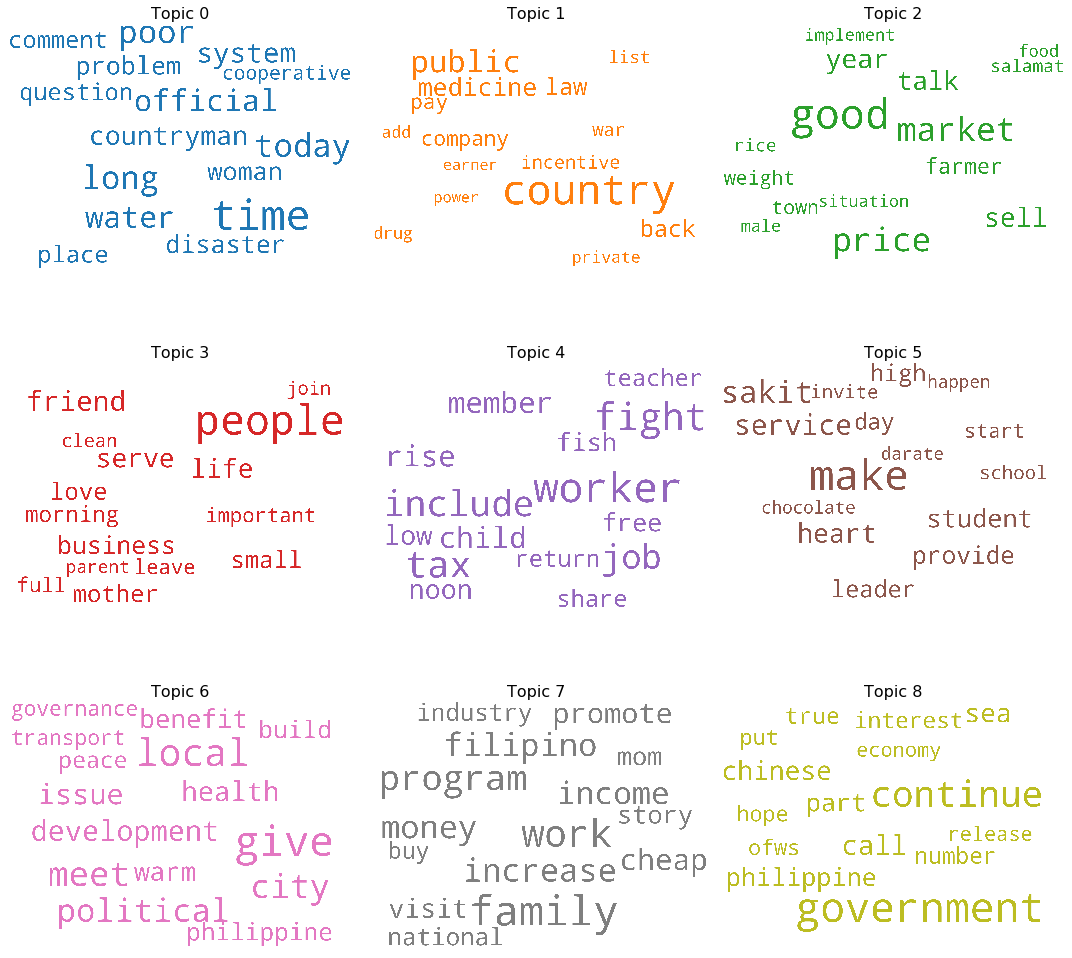

In [29]:
# Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False, num_words=15)

fig, axes = plt.subplots(3, 3, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Save Results

In [31]:
get_document_topics = optimal_model2.get_document_topics(corpus, minimum_probability=0.0)

In [32]:
len(get_document_topics)

839

In [33]:
topic0 = []
topic1 = []
topic2 = []
topic3 = []
topic4 = []
topic5 = []
topic6 = []
topic7 = []
topic8 = []

for score in get_document_topics:
    for col in score:
        if col[0] == 0:
            topic0.append(col[1])
        elif col[0] == 1:
            topic1.append(col[1])
        elif col[0] == 2:
            topic2.append(col[1])
        elif col[0] == 3:
            topic3.append(col[1])
        elif col[0] == 4:
            topic4.append(col[1])
        elif col[0] == 5:
            topic5.append(col[1])
        elif col[0] == 6:
            topic6.append(col[1])
        elif col[0] == 7:
            topic7.append(col[1])
        elif col[0] == 8:
            topic8.append(col[1])
        elif col[0] == 9:
            topic9.append(col[1])
            
            
print(len(topic0), len(topic1), len(topic2))
print(len(topic3), len(topic4), len(topic5))
print(len(topic6), len(topic7), len(topic8))

839 839 839
839 839 839
839 839 839


In [34]:
df['Topic 0'] = topic0
df['Topic 1'] = topic1
df['Topic 2'] = topic2
df['Topic 3'] = topic3
df['Topic 4'] = topic4
df['Topic 5'] = topic5
df['Topic 6'] = topic6
df['Topic 7'] = topic7
df['Topic 8'] = topic8

In [35]:
df['Dominant Topic'] = df_dominant_topic['Dominant_Topic'].values
df

,Candidate,Translated_text,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Dominant Topic
0,Bong Go,Happy Mother's Day From Tatay Digong!,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.0
3,Bong Go,Vhong Navarro has shown support for Kuya Bong ...,0.108932,0.128540,0.108932,0.108932,0.108932,0.108932,0.108932,0.108932,0.108932,1.0
4,Bong Go,"Bong Go at Cogon Public Market, Cagayan de Oro...",0.108932,0.108932,0.128540,0.108932,0.108932,0.108932,0.108932,0.108932,0.108932,2.0
9,Bong Go,"VERY GOOD AND SO MUCH BONG GO, SHOWING SUPPORT...",0.190767,0.113565,0.085673,0.081051,0.120988,0.127413,0.116075,0.067103,0.097366,0.0
12,Charlie Gaddi,The people will continue to fight for hope and...,0.124798,0.101010,0.101010,0.119192,0.119192,0.101010,0.101010,0.101010,0.131768,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2655,Mar Roxas,"Good to be back in San Pablo, known as the Cit...",0.101010,0.119192,0.118038,0.101010,0.119192,0.101175,0.138363,0.101010,0.101010,6.0
2657,Mar Roxas,Nagulat ako sa nakita kong maliliit na repolyo...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.0
2659,Mar Roxas,Saludo ako sa lahat ng masisipag at tapat na m...,0.128540,0.108932,0.108932,0.108932,0.108932,0.108932,0.108932,0.108932,0.108932,0.0
2660,Mar Roxas,Nakilala ko ang mag-asawang sina Joseph at Mar...,0.114591,0.104822,0.104822,0.123690,0.104822,0.104822,0.123690,0.113920,0.104822,3.0


In [36]:
#df.to_csv('fb_topic_model_9topics.csv')